train.info()

In [5]:
import os
import logging
from typing import Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.exceptions import NotFittedError

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s [%(levelname)s] %(message)s',
    handlers=[
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

def load_data(filepath: str) -> pd.DataFrame:
    """Load dataset from a CSV file."""
    try:
        df = pd.read_csv(filepath)
        logger.info(f"Data loaded successfully from {filepath}.")
        return df
    except FileNotFoundError as e:
        logger.error(f"File not found: {filepath}")
        raise e
    except pd.errors.ParserError as e:
        logger.error(f"Error parsing the file: {filepath}")
        raise e

def remove_outliers(df: pd.DataFrame, column: str) -> pd.DataFrame:
    """Remove outliers from a DataFrame based on the IQR method."""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_threshold = Q1 - 1.5 * IQR
    upper_threshold = Q3 + 1.5 * IQR
    initial_shape = df.shape
    df_filtered = df[(df[column] >= lower_threshold) & (df[column] <= upper_threshold)].copy()
    final_shape = df_filtered.shape
    logger.info(f"Outliers removed from '{column}'. Shape: {initial_shape} -> {final_shape}")
    return df_filtered

def preprocess_data(
    df: pd.DataFrame,
    num_features: list,
    cat_features: list,
    dummy_features: list
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, ColumnTransformer]:
    """Preprocess the data: impute, encode, and split into train/test."""
    
    X = df[num_features + dummy_features + cat_features]
    y = df["price"]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=535
    )
    logger.info("Data split into training and testing sets.")
    
    # Define preprocessing for numerical features
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean'))
    ])
    
    # Define preprocessing for categorical features
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
    ])
    
    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, num_features),
            ('dummy', 'passthrough', dummy_features),
            ('cat', categorical_transformer, cat_features)
        ]
    )
    
    # Fit and transform the training data, transform the test data
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    logger.info("Data preprocessing completed.")
    
    return X_train_processed, X_test_processed, y_train.values, y_test.values, preprocessor

def train_model(X_train: np.ndarray, y_train: np.ndarray) -> xgb.XGBRegressor:
    """Train the XGBoost regressor."""
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=535)
    model.fit(X_train, y_train)
    logger.info("XGBoost model trained successfully.")
    return model

def evaluate_model(
    model: xgb.XGBRegressor,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray
) -> None:
    """Evaluate the model and log the performance metrics."""
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    
    logger.info(f"R-squared (Train): {r2_train:.4f}")
    logger.info(f"R-squared (Test): {r2_test:.4f}")
    
    # Cross-validation
    try:
        cv_scores = cross_val_score(
            model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
        )
        mse_scores = -cv_scores
        logger.info(f"Mean Squared Error for each fold: {mse_scores}")
        logger.info(f"Average Cross-Validated MSE: {mse_scores.mean():.4f}")
    except NotFittedError as e:
        logger.error("Model is not fitted yet. Cannot perform cross-validation.")
        raise e

def plot_actual_vs_predicted(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    dataset_type: str,
    save_dir: str = 'plots'
) -> None:
    """Plot actual vs. predicted prices."""
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.5, label='Predictions', color='blue')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 
             color='red', linestyle='--', label='Ideal Fit')
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.title(f'Actual vs. Predicted Prices ({dataset_type} Set)')
    plt.legend()
    plt.tight_layout()
    
    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)
    plot_path = os.path.join(save_dir, f'actual_vs_predicted_{dataset_type.lower()}.png')
    plt.savefig(plot_path)
    logger.info(f"Plot saved to {plot_path}.")
    plt.show()

def save_model(model: xgb.XGBRegressor, preprocessor: ColumnTransformer, filepath: str) -> None:
    """Save the trained model and preprocessor to disk."""
    model_package = {
        'model': model,
        'preprocessor': preprocessor
    }
    joblib.dump(model_package, filepath)
    logger.info(f"Trained model and preprocessor saved to {filepath}.")

def create_comparison_dataframe(y_test: np.ndarray, y_pred_test: np.ndarray) -> pd.DataFrame:
    """Create a DataFrame comparing actual and predicted prices."""
    comparison_df = pd.DataFrame({
        'Actual Price': y_test,
        'Predicted Price': y_pred_test
    })
    comparison_df['Absolute Error'] = np.abs(comparison_df['Actual Price'] - comparison_df['Predicted Price'])
    comparison_df['Percentage Error'] = (comparison_df['Absolute Error'] / comparison_df['Actual Price']) * 100
    logger.info("Comparison DataFrame created.")
    return comparison_df.head(10)

def main():
    # Define file paths
    data_filepath = 'Data\Preprocessed\houses_sqm.csv'
    model_filepath = 'trained_xgb_model.pkl'
    plots_directory = 'plots'
    
    # Define feature categories
    cat_features = ['zip_code', 'state_building', 'province', 'region']
    num_features = ["total_area_sqm", "nbr_frontages", "nbr_bedrooms"]
    dummy_features = ["fl_garden", "fl_furnished", "fl_open_fire", "fl_terrace", 
                      "fl_swimming_pool", "fl_floodzone", "fl_double_glazing"]
    
    # Load data
    df = load_data(data_filepath)
    
    # Remove outliers
    df = remove_outliers(df, 'price')
    
    # Preprocess data
    X_train, X_test, y_train, y_test, preprocessor = preprocess_data(
        df, num_features, cat_features, dummy_features
    )
    
    # Train model
    model = train_model(X_train, y_train)
    
    # Evaluate model
    evaluate_model(model, X_train, y_train, X_test, y_test)
    
    # Predict for visualization
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Plot Actual vs Predicted for Training Set
    plot_actual_vs_predicted(y_train, y_pred_train, 'Training', plots_directory)
    
    # Plot Actual vs Predicted for Test Set
    plot_actual_vs_predicted(y_test, y_pred_test, 'Test', plots_directory)
    
    # Save the model and preprocessor
    save_model(model, preprocessor, model_filepath)
    
    # Create and display comparison DataFrame
    comparison_df = create_comparison_dataframe(y_test, y_pred_test)
    print(comparison_df)

if __name__ == "__main__":
    main()


<>:177: SyntaxWarning: invalid escape sequence '\P'
<>:177: SyntaxWarning: invalid escape sequence '\P'
C:\Users\Becode-son\AppData\Local\Temp\ipykernel_8280\2626511883.py:177: SyntaxWarning: invalid escape sequence '\P'
  data_filepath = 'Data\Preprocessed\houses_sqm.csv'
2024-11-05 11:54:38,155 [ERROR] File not found: Data\Preprocessed\houses_sqm.csv


FileNotFoundError: [Errno 2] No such file or directory: 'Data\\Preprocessed\\houses_sqm.csv'

2024-11-05 12:43:02,437 [INFO] Data loaded successfully from C:\Users\Becode-son\Documents\Machine_Learning_Becode\ml_immoweb\Data\Preprocessed\houses_sqm.csv.
2024-11-05 12:43:02,453 [INFO] Outliers removed from 'price'. Shape: (21797, 30) -> (21702, 30)
2024-11-05 12:43:02,466 [INFO] Data split into training and testing sets.
c:\Users\Becode-son\Documents\Machine_Learning_Becode\ml_immoweb\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
2024-11-05 12:43:02,724 [INFO] Data preprocessing completed.
2024-11-05 12:43:04,266 [INFO] XGBoost model trained successfully.
2024-11-05 12:43:04,388 [INFO] R-squared (Train): 0.7426
2024-11-05 12:43:04,389 [INFO] R-squared (Test): 0.6839
2024-11-05 12:43:22,301 [INFO] Mean Squared Error for each fold: [6.67800731e+09 6.23776815e+09 6.15056158e+09 6.47411182e+09
 5.95679345e+09]
2024-11-05 12:43

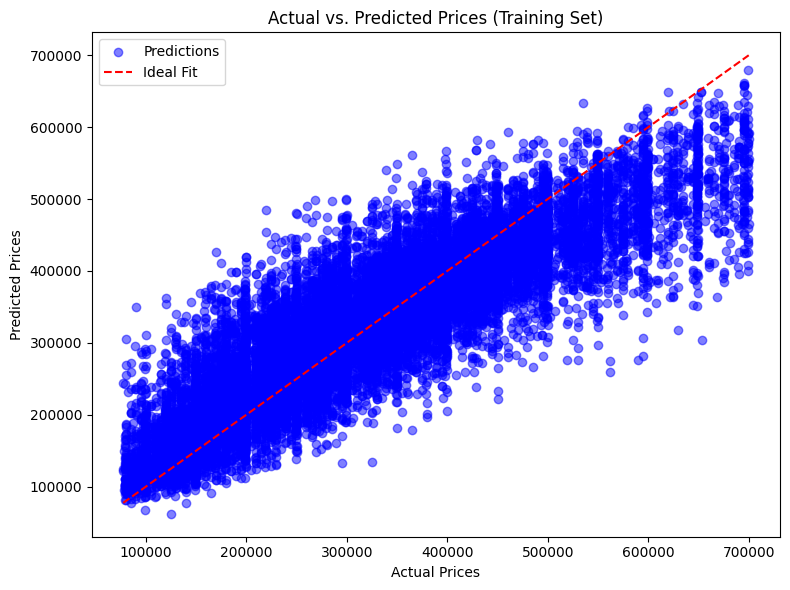

2024-11-05 12:43:23,334 [INFO] Plot saved to plots\actual_vs_predicted_test.png.


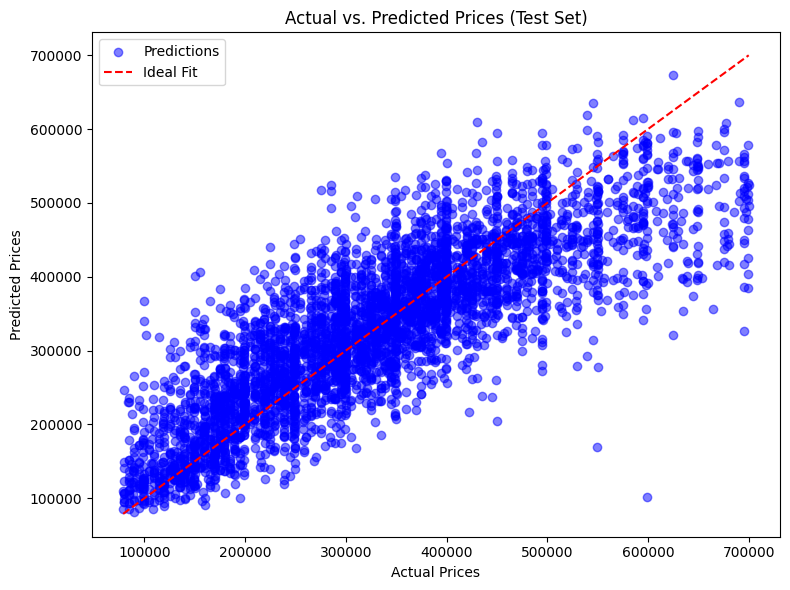

2024-11-05 12:43:23,513 [INFO] Trained model and preprocessor saved to trained_xgb_model.joblib.
2024-11-05 12:43:23,517 [INFO] Comparison DataFrame created.


   Actual Price  Predicted Price  Absolute Error  Percentage Error
0      345000.0    329622.531250    15377.468750          4.457237
1      399000.0    419599.906250    20599.906250          5.162884
2      570000.0    478219.875000    91780.125000         16.101776
3      479000.0    428502.906250    50497.093750         10.542191
4      373673.0    387135.750000    13462.750000          3.602816
5      439000.0    517481.093750    78481.093750         17.877242
6      399000.0    475349.437500    76349.437500         19.135197
7      375000.0    342454.312500    32545.687500          8.678850
8      170000.0    126183.320312    43816.679688         25.774517
9      295000.0    212055.375000    82944.625000         28.116822


In [15]:
import os
import logging
from typing import Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.exceptions import NotFittedError

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s [%(levelname)s] %(message)s',
    handlers=[
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

def load_data(filepath: str) -> pd.DataFrame:
    """Load dataset from a CSV file."""
    try:
        df = pd.read_csv(filepath)
        logger.info(f"Data loaded successfully from {filepath}.")
        return df
    except FileNotFoundError as e:
        logger.error(f"File not found: {filepath}")
        raise e
    except pd.errors.ParserError as e:
        logger.error(f"Error parsing the file: {filepath}")
        raise e

def remove_outliers(df: pd.DataFrame, column: str) -> pd.DataFrame:
    """Remove outliers from a DataFrame based on the IQR method."""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_threshold = Q1 - 1.5 * IQR
    upper_threshold = Q3 + 1.5 * IQR
    initial_shape = df.shape
    df_filtered = df[(df[column] >= lower_threshold) & (df[column] <= upper_threshold)].copy()
    final_shape = df_filtered.shape
    logger.info(f"Outliers removed from '{column}'. Shape: {initial_shape} -> {final_shape}")
    return df_filtered

def preprocess_data(
    df: pd.DataFrame,
    num_features: list,
    cat_features: list,
    dummy_features: list
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, ColumnTransformer]:
    """Preprocess the data: impute, encode, and split into train/test."""
    
    X = df[num_features + dummy_features + cat_features]
    y = df["price"]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=535
    )
    logger.info("Data split into training and testing sets.")
    
    # Define preprocessing for numerical features
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean'))
    ])
    
    # Define preprocessing for categorical features
    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
    ])
    
    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, num_features),
            ('dummy', 'passthrough', dummy_features),
            ('cat', categorical_transformer, cat_features)
        ]
    )
    
    # Fit and transform the training data, transform the test data
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    logger.info("Data preprocessing completed.")
    
    return X_train_processed, X_test_processed, y_train.values, y_test.values, preprocessor

def train_model(X_train: np.ndarray, y_train: np.ndarray) -> xgb.XGBRegressor:
    """Train the XGBoost regressor."""
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=535)
    model.fit(X_train, y_train)
    logger.info("XGBoost model trained successfully.")
    return model

def evaluate_model(
    model: xgb.XGBRegressor,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray
) -> None:
    """Evaluate the model and log the performance metrics."""
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    
    logger.info(f"R-squared (Train): {r2_train:.4f}")
    logger.info(f"R-squared (Test): {r2_test:.4f}")
    
    # Cross-validation
    try:
        cv_scores = cross_val_score(
            model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
        )
        mse_scores = -cv_scores
        logger.info(f"Mean Squared Error for each fold: {mse_scores}")
        logger.info(f"Average Cross-Validated MSE: {mse_scores.mean():.4f}")
    except NotFittedError as e:
        logger.error("Model is not fitted yet. Cannot perform cross-validation.")
        raise e

def plot_actual_vs_predicted(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    dataset_type: str,
    save_dir: str = 'plots'
) -> None:
    """Plot actual vs. predicted prices."""
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.5, label='Predictions', color='blue')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 
             color='red', linestyle='--', label='Ideal Fit')
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.title(f'Actual vs. Predicted Prices ({dataset_type} Set)')
    plt.legend()
    plt.tight_layout()
    
    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)
    plot_path = os.path.join(save_dir, f'actual_vs_predicted_{dataset_type.lower()}.png')
    plt.savefig(plot_path)
    logger.info(f"Plot saved to {plot_path}.")
    plt.show()

def save_model(model: xgb.XGBRegressor, preprocessor: ColumnTransformer, filepath: str) -> None:
    """Save the trained model and preprocessor to disk."""
    model_package = {
        'model': model,
        'preprocessor': preprocessor
    }
    joblib.dump(model_package, filepath)
    logger.info(f"Trained model and preprocessor saved to {filepath}.")

def create_comparison_dataframe(y_test: np.ndarray, y_pred_test: np.ndarray) -> pd.DataFrame:
    """Create a DataFrame comparing actual and predicted prices."""
    comparison_df = pd.DataFrame({
        'Actual Price': y_test,
        'Predicted Price': y_pred_test
    })
    comparison_df['Absolute Error'] = np.abs(comparison_df['Actual Price'] - comparison_df['Predicted Price'])
    comparison_df['Percentage Error'] = (comparison_df['Absolute Error'] / comparison_df['Actual Price']) * 100
    logger.info("Comparison DataFrame created.")
    return comparison_df.head(10)

def main():
    # Define file paths
    data_filepath = r'C:\Users\Becode-son\Documents\Machine_Learning_Becode\ml_immoweb\Data\Preprocessed\houses_sqm.csv'
    model_filepath = 'trained_xgb_model.joblib'
    plots_directory = 'plots'
    
    # Define feature categories
    cat_features = ['zip_code', 'state_building', 'province', 'region']
    num_features = ["total_area_sqm", "nbr_frontages", "nbr_bedrooms"]
    dummy_features = ["fl_garden", "fl_furnished", "fl_open_fire", "fl_terrace", 
                      "fl_swimming_pool", "fl_floodzone", "fl_double_glazing"]
    
    # Load data
    df = load_data(data_filepath)
    
    # Remove outliers
    df = remove_outliers(df, 'price')
    
    # Preprocess data
    X_train, X_test, y_train, y_test, preprocessor = preprocess_data(
        df, num_features, cat_features, dummy_features
    )
    
    # Train model
    model = train_model(X_train, y_train)
    
    # Evaluate model
    evaluate_model(model, X_train, y_train, X_test, y_test)
    
    # Predict for visualization
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Plot Actual vs Predicted for Training Set
    plot_actual_vs_predicted(y_train, y_pred_train, 'Training', plots_directory)
    
    # Plot Actual vs Predicted for Test Set
    plot_actual_vs_predicted(y_test, y_pred_test, 'Test', plots_directory)
    
    # Save the model and preprocessor
    save_model(model, preprocessor, model_filepath)
    
    # Create and display comparison DataFrame
    comparison_df = create_comparison_dataframe(y_test, y_pred_test)
    print(comparison_df)

if __name__ == "__main__":
    main()


###TEST
